## Download DataSet from Kaggle To Colab

### Use this only if Competition content exist on googledrive
- drive/My Drive/Covid19_Datagen
- inside folder Covid19_Datagen

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Upload competition content to google drive

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install --upgrade pip
!pip install kaggle==1.5.6
!kaggle -v
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!kaggle -v
!kaggle competitions download -c deep-learning-competition-cs-2020

     |████████████████████████████████| 1.5MB 2.8MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
Kaggle API 1.5.4
Found existing installation: kaggle 1.5.6
Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (20.1)
     |████████████████████████████████| 58 kB 1.6 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72859 sha256=055eb5e5d40afc26b138450a76b4997ae30ab6344756beecf8a06877e994a220
  Stored in directory: /root/.cache/pip/wheels/01/3e/ff/77407ebac3ef71a79b9166a8382aecf88415a0bcbe3c095a01
Successfully built kaggle
Kaggle API 1.5.6
 99% 1.17G/1.18G [00:11<00:00, 119MB/s]
100% 1.18G/1.18G [00:11<00:00, 113MB/s]


Unzip the data into my drive Folder (Covid19_Datagen)

In [ ]:
import zipfile
directory="/content/drive/My Drive/Covid19_Datagen"
zip_ref = zipfile.ZipFile("/content/deep-learning-competition-cs-2020.zip", 'r')
zip_ref.extractall(directory)
zip_ref.close()

## Preprocessing (Prepare Data)

#### All Important libraries

In [2]:
import cv2
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

#### Taking testfile names & trainfile names from their paths

In [13]:
testPath = "/content/drive/My Drive/Covid19_Datagen/test/test"
#testfiles = os.listdir(testPath)

trainC19Path = "/content/drive/My Drive/Covid19_Datagen/train/train/COVID19 AND PNEUMONIA"
trainNormalPath = "/content/drive/My Drive/Covid19_Datagen/train/train/NORMAL"

#trainC19files = os.listdir(trainC19Path)
#trainNormalfiles = os.listdir(trainNormalPath)

### Preparing Train Data

#### Create Contrast Limited Adaptive Histogram Equalization [CLAHE]
-  to enhance the visibility level of pneumonia clouds in the X-ray images

In [14]:
def CreateCLAHE(img, rsize, csize):
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  if img.shape[2] == 3:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  out_img = clahe.apply(img)
  return out_img

#### Fn Create_train_label, create_data :
- label normal => 0, COVID19 => 1
- intialize img size (rows, columns, channels)
- read the image by imread on grayscale (0) if channels = 1
- read the image by imread on bgr (colors) covert to RGB
- resize the image, interpolation cubic to be sharper
- concat both img_data and label

In [15]:
def create_train_label(img_name, pathDir):
  
  if pathDir.split('/')[-1] == 'NORMAL':
    #return np.array([1,0])
    return np.array([0])
  elif pathDir.split('/')[-1] == 'COVID19 AND PNEUMONIA':
    #return np.array([0,1])
    return np.array([1])

create_clahe = True
img_rsize = 256
img_csize = 256
img_channels = 3
def create_data(pathDir, d = []):
  data = d
  for img in tqdm(os.listdir(pathDir)):    # img names
    
    img_path = os.path.join(pathDir, img)  # path of the image 
    
    if img_channels == 3:
      img_data = cv2.imread(img_path, cv2.IMREAD_COLOR)
      img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB) 
    else:
      img_data = cv2.imread(img_path, 0)

    img_data = cv2.resize(img_data, (img_rsize, img_csize), interpolation = cv2.INTER_CUBIC)

    if create_clahe:
      img_data = CreateCLAHE(img_data, img_rsize, img_csize)
      if img_channels == 3:
        img_data = cv2.cvtColor(img_data, cv2.COLOR_GRAY2RGB)
    
    data.append([np.array(img_data), create_train_label(img, pathDir)]) 
  
  return data

##### Load Data
- load data doesn't work , **allow_pickle** has to be true
- then load data

In [6]:
def load_data(path_name):
  np_load_old = np.load
  
  # modify the default parameters of np.load
  np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

  data = np.load(path_name)

  np.load = np_load_old

  return data

#### load data if exist, else create data and save it inside the drive

In [7]:
CV19_path = "/content/drive/My Drive/Covid19_Datagen/"

if os.path.exists('/content/drive/My Drive/Covid19_Datagen/train_data3D.npy'):
  train_data = load_data('/content/drive/My Drive/Covid19_Datagen/train_data3D.npy')
else:
  train_C19_data = create_data(trainC19Path)
  train_data = create_data(trainNormalPath, train_C19_data)
  np.random.shuffle(train_data)
  np.save(f'{CV19_path}train_data3D.npy', train_data)

#### Reshape both x_train, y_train, use train test split
- reshaping x -> (#, nrows, ncols, nchannels), y -> (#)
- train_test_split -> test size 20%, random_state=42 to be the same each time 

In [16]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

x_train = np.array([i[0] for i in train_data]).reshape(-1, img_rsize, img_csize, img_channels)
y_train = np.array([i[1] for i in train_data]).reshape(-1)

X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

### Preparing Test Data

#### Create_test_data
- take each img path from list dir
- read the image by imread on grayscale (0) if channels = 1
- else read the image by imread on bgr (colors) covert to RGB
- resize the image, interpolation cubic to be sharper


In [17]:
CV19_path = "/content/drive/My Drive/Covid19_Datagen/"
testPath = "/content/drive/My Drive/Covid19_Datagen/test/test"
testfiles = os.listdir(testPath)


def Create_test_data(pathDir):
  data = []
  for img in tqdm(os.listdir(pathDir)):

    img_path = os.path.join(pathDir, img)
    
    if img_channels == 3:
      img_data = cv2.imread(img_path, cv2.IMREAD_COLOR)
      img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
    else:
      img_data = cv2.imread(img_path, 0)
    
    img_data = cv2.resize(img_data, (img_rsize, img_csize), interpolation = cv2.INTER_CUBIC)
    
    if create_clahe:
      img_data = CreateCLAHE(img_data, img_rsize, img_csize)
      if img_channels == 3:
        img_data = cv2.cvtColor(img_data, cv2.COLOR_GRAY2RGB)
    
    ## RE
    if img[:2] == 'NO':
      data.append([np.array(img_data), np.array([0])])
    elif img[:2] == 'IM':
      data.append([np.array(img_data), np.array([1])])
    else:
      print("NOT")
      data.append([np.array(img_data), np.array([1])])

  return data

#### Read test data if exist, Else Create data and save

In [18]:
if os.path.exists('/content/drive/My Drive/Covid19_Datagen/test_data3D.npy'):
  test_data = load_data('/content/drive/My Drive/Covid19_Datagen/test_data3D.npy')
else:
  test_data = Create_test_data(testPath)
  np.save(f'{CV19_path}test_data3D.npy', test_data)

### Data Augmentation

In [22]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40,
                                         width_shift_range=0.2,height_shift_range=0.2,
                                         shear_range=0.2,zoom_range=0.2,
                                         horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

#train = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
#test = test_datagen.flow(X_test, y_test, batch_size=BATCH_SIZE)

## Creating Model

#### Import important libraries from keras
- layers for conv and pooling
- optimizers for any backpropagtion algorithm


In [23]:
from keras import Input
from keras import layers
from keras import optimizers
from keras import models

from keras.utils import plot_model
from keras.layers.merge import concatenate

#from keras.applications.vgg16 import VGG16
#from keras.applications import InceptionResNetV2
#from keras.applications.inception_v3 import InceptionV3
#from keras.applications.xception import Xception

In [24]:
BATCH_SIZE = 8
EPOCHS = 20
LEARNING_RATE = 0.0005

train = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
test = test_datagen.flow(X_test, y_test, batch_size=BATCH_SIZE)

In [26]:
saved_models = "/content/drive/My Drive/Covid19_Datagen/saved_model/"
isSaved_model = False

##### First Module

In [27]:
if not isSaved_model:
  
  model = models.Sequential()

  model.add(layers.Conv2D(32, (3,3),activation='relu', input_shape=(img_rsize, img_csize, img_channels)))
  model.add(layers.MaxPool2D((2,2)))

  model.add(layers.Conv2D(64, (3,3),activation='relu'))
  model.add(layers.Conv2D(64, (3,3),activation='relu'))
  model.add(layers.MaxPool2D((2,2)))

  model.add(layers.Conv2D(128, (3,3),activation='relu'))
  model.add(layers.Conv2D(128, (3,3),activation='relu'))
  model.add(layers.MaxPool2D((2,2)))

  model.add(layers.Flatten())

  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dropout(0.5))

  model.add(layers.Dense(1, activation='sigmoid')) # 0 , 1
  model.summary()
  plot_model(model, show_shapes=True, to_file='1st_Model.png')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 123, 123, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 59, 59, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 57, 57, 128)       1

In [28]:
model.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',
              metrics=['acc'])

In [ ]:
trained_model = model.fit_generator(train, steps_per_epoch= len(X_train) // BATCH_SIZE,
                                    epochs=EPOCHS, validation_data=test,
                                    validation_steps= len(X_test) // BATCH_SIZE)
model.save(CV19_path+'TrainedModel_1')

#### Model 2 Single Conv Simplest Module

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 115200)            0

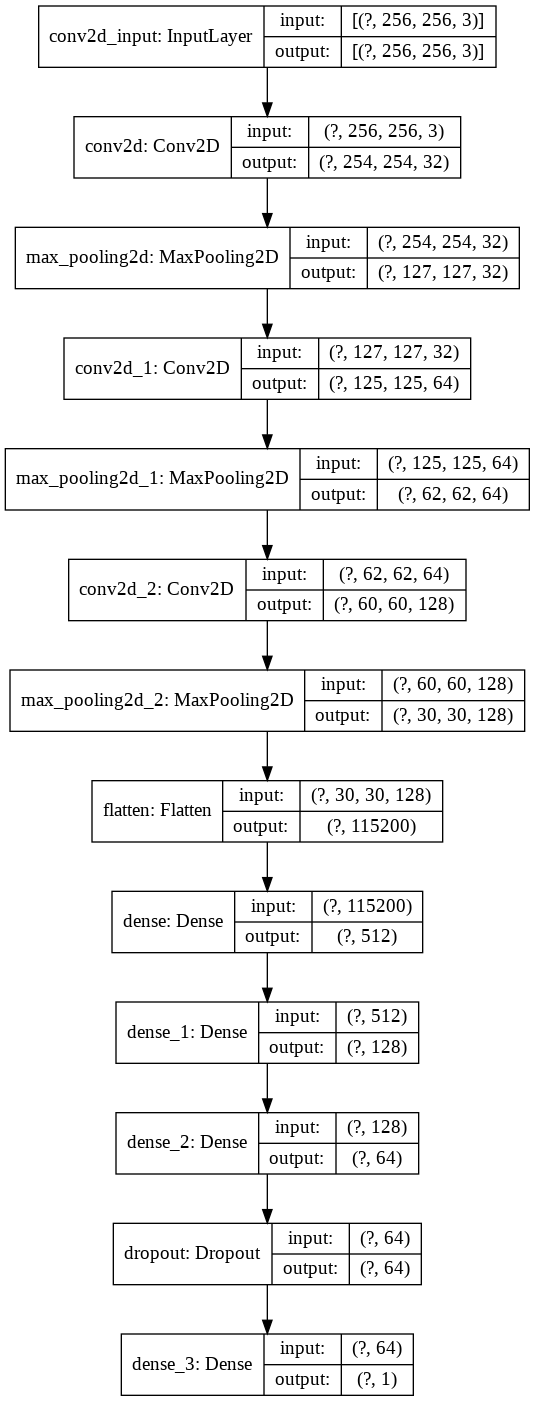

In [ ]:
model_s = models.Sequential()

model_s.add(layers.Conv2D(32, (3,3),activation='relu', input_shape=(img_rsize, img_csize, img_channels)))
model_s.add(layers.MaxPool2D((2,2)))

model_s.add(layers.Conv2D(64, (3,3),activation='relu'))
model_s.add(layers.MaxPool2D((2,2)))

model_s.add(layers.Conv2D(128, (3,3),activation='relu'))
model_s.add(layers.MaxPool2D((2,2)))

model_s.add(layers.Flatten())

model_s.add(layers.Dense(512, activation='relu'))
model_s.add(layers.Dense(128, activation='relu'))
model_s.add(layers.Dense(64, activation='relu'))
model_s.add(layers.Dropout(0.2))

model_s.add(layers.Dense(1, activation='sigmoid')) # 0 , 1
model_s.summary()
plot_model(model_s, show_shapes=True, to_file='2nd_Model.png')

In [ ]:
model_s.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',
              metrics=['acc'])
model_s.fit_generator(train, steps_per_epoch=len(X_train) // BATCH_SIZE,
                                    epochs=EPOCHS, validation_data=test,
                                    validation_steps=len(X_test) // BATCH_SIZE)
model_s.save(CV19_path+'TrainedModel_2nd')

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
526/526 [==============================] - 62s 117ms/step - loss: 0.3572 - acc: 0.8375 - val_loss: 0.4216 - val_acc: 0.8855
Epoch 2/20
526/526 [==============================] - 61s 116ms/step - loss: 0.2987 - acc: 0.8735 - val_loss: 0.4957 - val_acc: 0.7567
Epoch 3/20
526/526 [==============================] - 60s 115ms/step - loss: 0.2795 - acc: 0.8832 - val_loss: 0.4509 - val_acc: 0.7538
Epoch 4/20
526/526 [==============================] - 60s 113ms/step - loss: 0.2722 - acc: 0.8903 - val_loss: 0.3626 - val_acc: 0.8158
Epoch 5/20
526/526 [==============================] - 60s 114ms/step - loss: 0.2565 - acc: 0.8965 - val_loss: 0.4207 - val_acc: 0.7681
Epoch 6/20
526/526 [==============================] - 59s 113ms/step - loss: 0.2466 - acc: 0.9003 - val_loss: 0.2937 - val_acc: 0.8635
Epoch 7/20
526/526 [==============================] - 59s 112ms/step - loss: 0.2332 - acc: 0.9053 - val_loss: 0.24

#### Model 3 My Inception

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 4736        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 64)   18496       max_pooling2d_1[0][0]            
____________________________________________________________________________________________

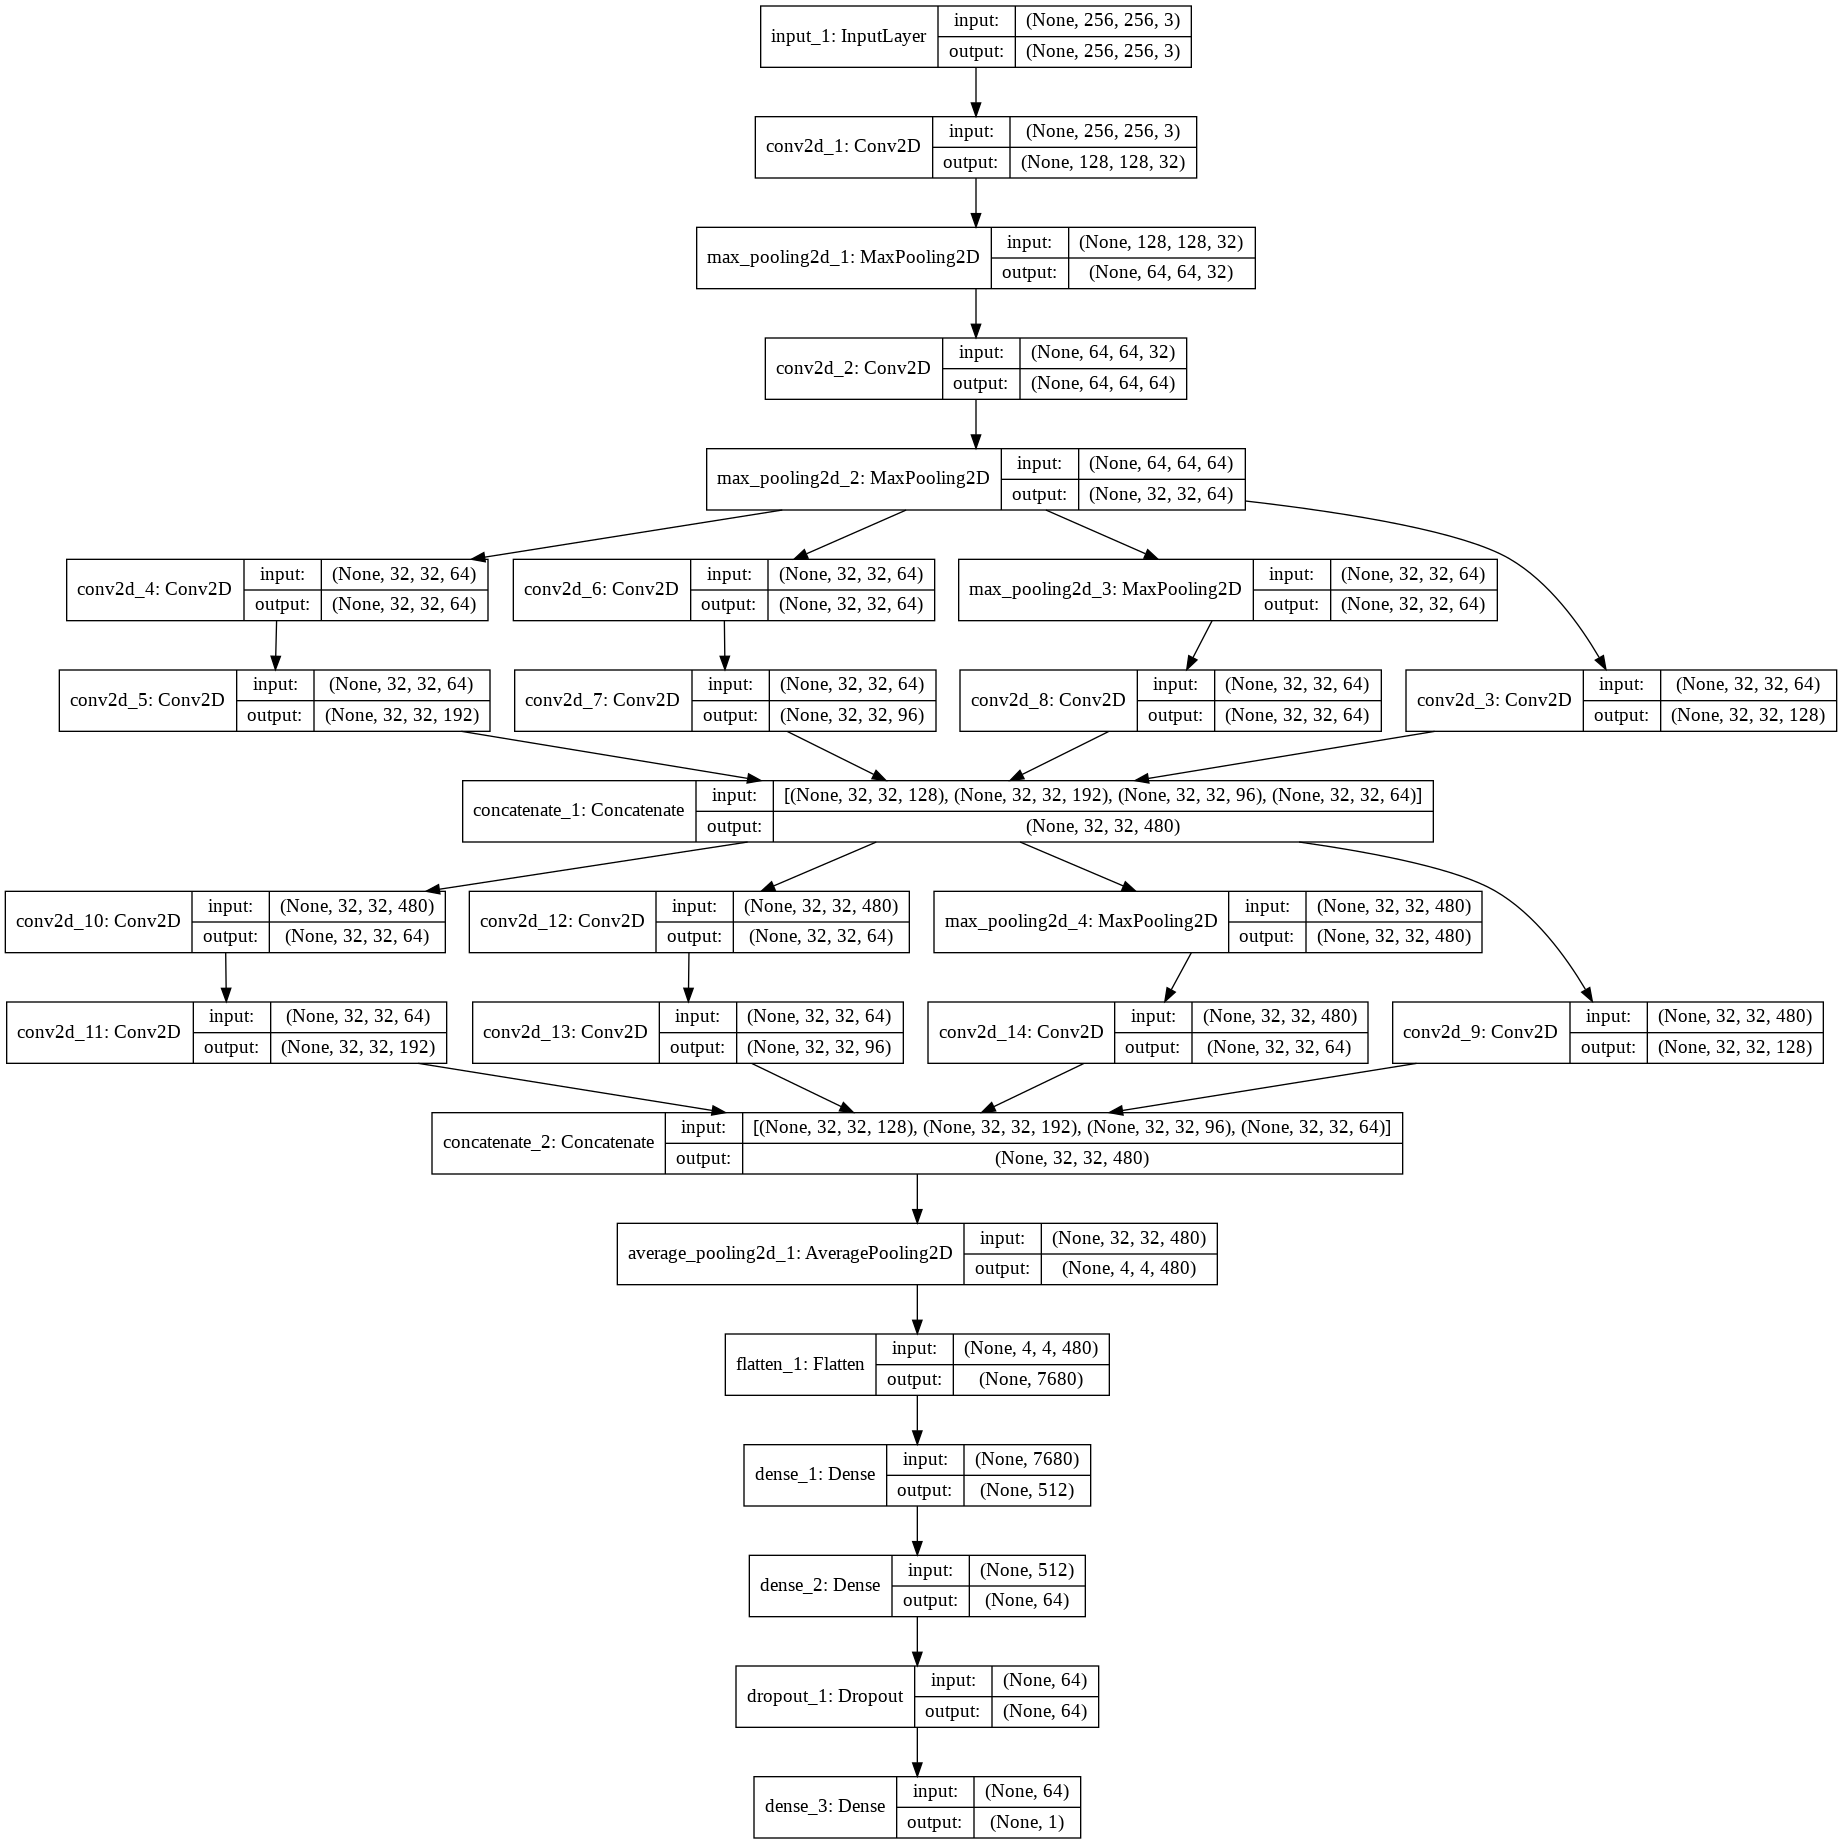

In [ ]:
##Similar to Full GoogleNet (partial)

ShapeInput = Input(shape=(img_rsize, img_csize, img_channels))

def Inception_module(input):
  conv1 = layers.Conv2D(128, (1,1), padding='same', activation='relu')(input)

  conv3 = layers.Conv2D(64, (1,1), padding='same', activation='relu')(input)
  conv3 = layers.Conv2D(192, (3,3), padding='same', activation='relu')(conv3)

  conv5 = layers.Conv2D(64, (1,1), padding='same', activation='relu')(input)
  conv5 = layers.Conv2D(96, (5,5), padding='same', activation='relu')(conv5)
 
  pool = layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(input)
  pool = layers.Conv2D(64, (1,1), padding='same', activation='relu')(pool)

  layer = concatenate([conv1, conv3, conv5, pool], axis=-1)

  return layer

## Arch

conv7 = layers.Conv2D(32, (7,7), strides=2, padding='same', activation='relu')(ShapeInput) #
pool3 = layers.MaxPooling2D((3,3), strides=2, padding='same')(conv7) #

conv3 = layers.Conv2D(64, (3,3), padding='same', activation='relu')(pool3) #
pool3 = layers.MaxPooling2D((3,3), strides=2, padding='same')(conv3) #

layer1 = Inception_module(pool3)
layer2 = Inception_module(layer1)

avgpool = layers.AvgPool2D((7,7))(layer2) #

flat = layers.Flatten()(avgpool)
D1 = layers.Dense(512, activation='relu')(flat)
D2 = layers.Dense(64, activation='relu')(D1)
dropout = layers.Dropout(0.3)(D2)

Outlayer = layers.Dense(1, activation='sigmoid')(dropout)

inception_model = models.Model(ShapeInput, Outlayer)

# summarize model
inception_model.summary()
plot_model(inception_model, show_shapes=True, to_file='inception_module.png')

In [ ]:
inception_model.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',
              metrics=['acc'])

inception_model.fit_generator(train, steps_per_epoch=len(X_train) // BATCH_SIZE,
                             epochs=EPOCHS, validation_data=test,
                             validation_steps=len(X_test) // BATCH_SIZE)

inception_model.save(CV19_path+'TrainedModel_inception_model')

Epoch 1/20
526/526 [==============================] - 615s 1s/step - loss: 0.4343 - acc: 0.7995 - val_loss: 0.3553 - val_acc: 0.8168
Epoch 2/20
526/526 [==============================] - 610s 1s/step - loss: 0.3290 - acc: 0.8463 - val_loss: 0.3949 - val_acc: 0.8164
Epoch 3/20
526/526 [==============================] - 609s 1s/step - loss: 0.3004 - acc: 0.8670 - val_loss: 0.1457 - val_acc: 0.8948
Epoch 4/20
526/526 [==============================] - 610s 1s/step - loss: 0.2843 - acc: 0.8758 - val_loss: 0.3660 - val_acc: 0.8786
Epoch 5/20
526/526 [==============================] - 607s 1s/step - loss: 0.2840 - acc: 0.8735 - val_loss: 0.1736 - val_acc: 0.9130
Epoch 6/20
526/526 [==============================] - 607s 1s/step - loss: 0.2751 - acc: 0.8799 - val_loss: 0.1300 - val_acc: 0.8996
Epoch 7/20
526/526 [==============================] - 608s 1s/step - loss: 0.2619 - acc: 0.8903 - val_loss: 0.1702 - val_acc: 0.9159
Epoch 8/20
526/526 [==============================] - 606s 1s/step - 

#### Model 4 Semi VGG16

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 128, 128, 128)     147584    
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 64, 64, 256)      

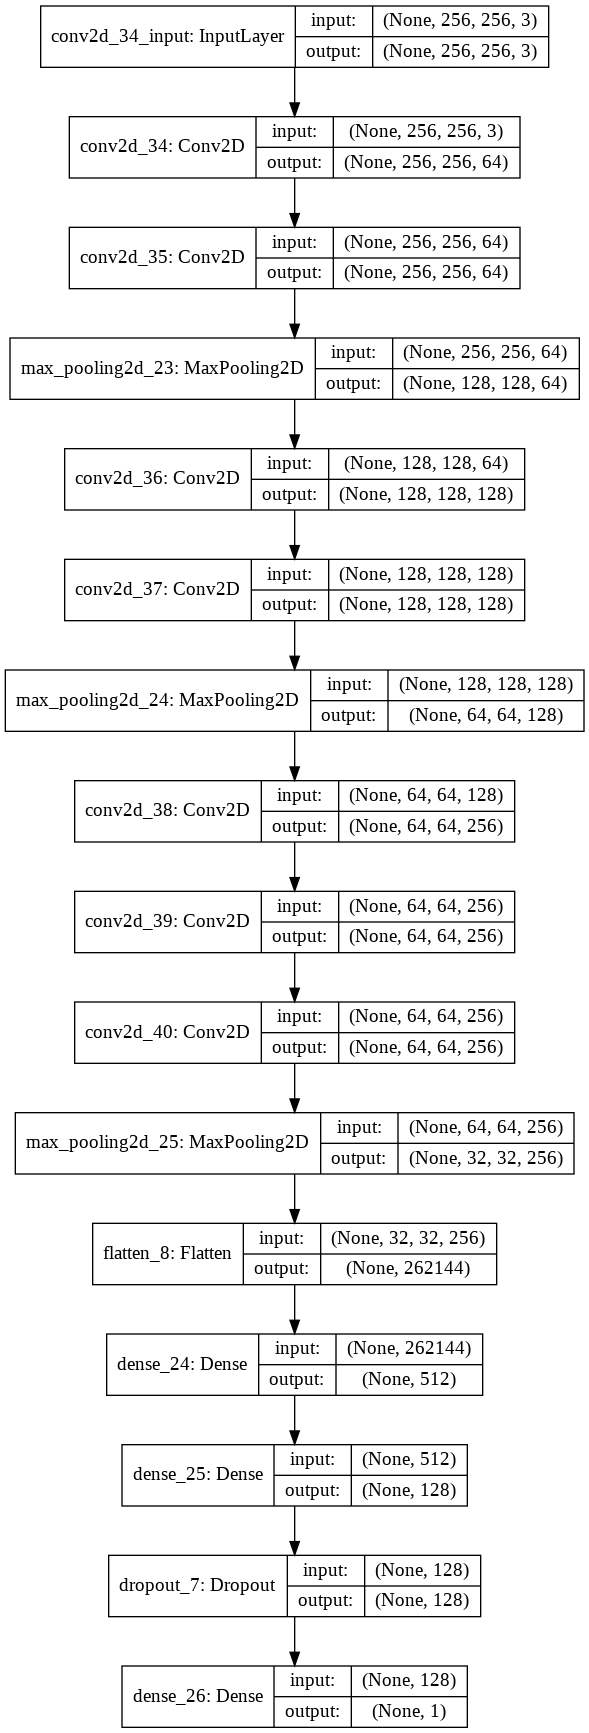

In [ ]:
model_m2 = models.Sequential()

model_m2.add(layers.Conv2D(64, (3,3),activation='relu', padding='same', input_shape=(img_rsize, img_csize, img_channels)))
model_m2.add(layers.Conv2D(64, (3,3),activation='relu', padding='same'))
model_m2.add(layers.MaxPool2D((2,2)))

model_m2.add(layers.Conv2D(128, (3,3),activation='relu', padding='same'))
model_m2.add(layers.Conv2D(128, (3,3),activation='relu', padding='same'))
model_m2.add(layers.MaxPool2D((2,2)))

model_m2.add(layers.Conv2D(256, (3,3),activation='relu', padding='same'))
model_m2.add(layers.Conv2D(256, (3,3),activation='relu', padding='same'))
model_m2.add(layers.Conv2D(256, (3,3),activation='relu', padding='same'))
model_m2.add(layers.MaxPool2D((2,2)))


model_m2.add(layers.Flatten())

model_m2.add(layers.Dense(512, activation='relu'))
model_m2.add(layers.Dense(128, activation='relu'))
model_m2.add(layers.Dropout(0.2))


model_m2.add(layers.Dense(1, activation='sigmoid')) # 0 , 1
model_m2.summary()
plot_model(model_m2, show_shapes=True, to_file='model_m2.png')

In [ ]:
model_m2.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',
              metrics=['acc'])

model_m2.fit_generator(train, steps_per_epoch=len(X_train) // BATCH_SIZE,
                             epochs=EPOCHS, validation_data=test,
                             validation_steps=len(X_test) // BATCH_SIZE)

model_m2.save(CV19_path+'TrainedModel_model_m2')

Epoch 1/20
526/526 [==============================] - 61s 115ms/step - loss: 0.4875 - acc: 0.7788 - val_loss: 0.5859 - val_acc: 0.7662
Epoch 2/20
526/526 [==============================] - 60s 114ms/step - loss: 0.4011 - acc: 0.8171 - val_loss: 0.3769 - val_acc: 0.6969
Epoch 3/20
526/526 [==============================] - 60s 114ms/step - loss: 0.4353 - acc: 0.7942 - val_loss: 0.5192 - val_acc: 0.7610
Epoch 4/20
526/526 [==============================] - 60s 114ms/step - loss: 0.4484 - acc: 0.7950 - val_loss: 0.5593 - val_acc: 0.7667
Epoch 5/20
526/526 [==============================] - 60s 113ms/step - loss: 0.3712 - acc: 0.8368 - val_loss: 0.6018 - val_acc: 0.6157
Epoch 6/20
526/526 [==============================] - 60s 113ms/step - loss: 0.3399 - acc: 0.8466 - val_loss: 0.1602 - val_acc: 0.8337
Epoch 7/20
526/526 [==============================] - 60s 114ms/step - loss: 0.3442 - acc: 0.8463 - val_loss: 0.3250 - val_acc: 0.6826
Epoch 8/20
526/526 [==============================] - 6

#### Full VGG19

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 128, 128)     147584    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 256)      

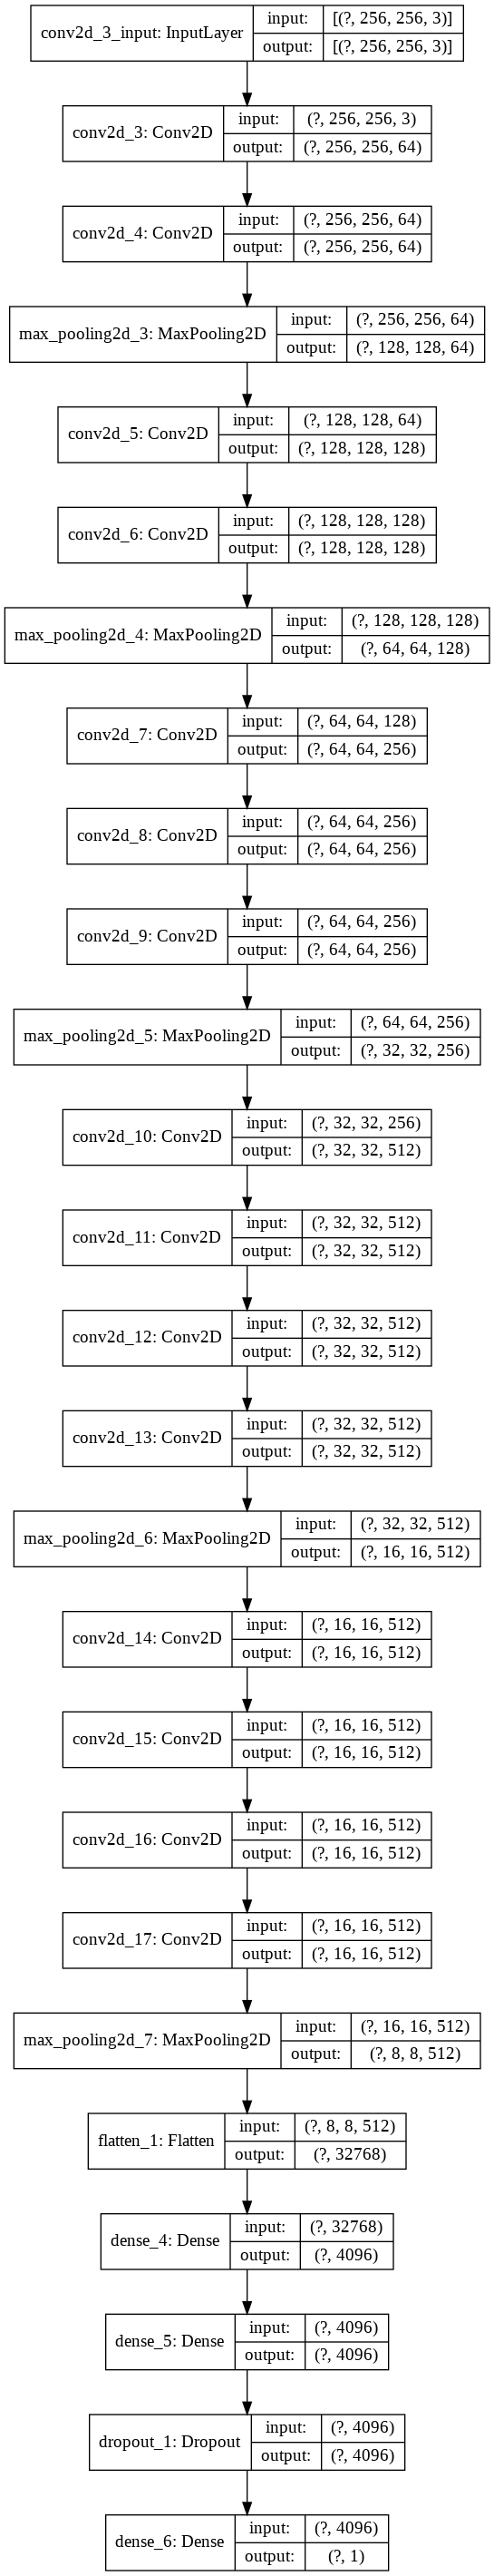

In [ ]:
model_VGG19 = models.Sequential()

model_VGG19.add(layers.Conv2D(64, (3,3),activation='relu', padding='same', input_shape=(img_rsize, img_csize, img_channels)))
model_VGG19.add(layers.Conv2D(64, (3,3),activation='relu', padding='same'))
model_VGG19.add(layers.MaxPool2D((2,2), strides=(2,2)))

model_VGG19.add(layers.Conv2D(128, (3,3),activation='relu', padding='same'))
model_VGG19.add(layers.Conv2D(128, (3,3),activation='relu', padding='same'))
model_VGG19.add(layers.MaxPool2D((2,2), strides=(2,2)))

model_VGG19.add(layers.Conv2D(256, (3,3),activation='relu', padding='same'))
model_VGG19.add(layers.Conv2D(256, (3,3),activation='relu', padding='same'))
model_VGG19.add(layers.Conv2D(256, (3,3),activation='relu', padding='same'))
model_VGG19.add(layers.MaxPool2D((2,2), strides=(2,2)))
model_VGG19.add(layers.Dropout(0.3))


model_VGG19.add(layers.Conv2D(512, (3,3),activation='relu', padding='same'))
model_VGG19.add(layers.Conv2D(512, (3,3),activation='relu', padding='same'))
model_VGG19.add(layers.Conv2D(512, (3,3),activation='relu', padding='same'))
model_VGG19.add(layers.Conv2D(512, (3,3),activation='relu', padding='same'))
model_VGG19.add(layers.MaxPool2D((2,2), strides=(2,2)))
model_VGG19.add(layers.Dropout(0.3))


model_VGG19.add(layers.Conv2D(512, (3,3),activation='relu', padding='same'))
model_VGG19.add(layers.Conv2D(512, (3,3),activation='relu', padding='same'))
model_VGG19.add(layers.Conv2D(512, (3,3),activation='relu', padding='same'))
model_VGG19.add(layers.Conv2D(512, (3,3),activation='relu', padding='same'))
model_VGG19.add(layers.MaxPool2D((2,2), strides=(2,2)))
model_VGG19.add(layers.Dropout(0.3))


model_VGG19.add(layers.Flatten())

model_VGG19.add(layers.Dense(4096, activation='relu'))
model_VGG19.add(layers.Dense(4096, activation='relu'))
model_VGG19.add(layers.Dropout(0.3))

model_VGG19.add(layers.Dense(1, activation='sigmoid')) # 0 , 1
model_VGG19.summary()
plot_model(model_VGG19, show_shapes=True, to_file='6th_Model.png')

In [ ]:
EPOCHS = 30
BATCH_SIZE = 32
model_VGG19.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',
              metrics=['acc'])

model_VGG19.fit_generator(train, steps_per_epoch=len(X_train) // BATCH_SIZE,
                             epochs=EPOCHS, validation_data=test,
                             validation_steps=len(X_test) // BATCH_SIZE)

model_VGG19.save(CV19_path+'model_VGG19_model_mod')

Epoch 1/30
131/131 [==============================] - 17s 129ms/step - loss: 0.5914 - acc: 0.7223 - val_loss: 0.5540 - val_acc: 0.7617
Epoch 2/30
131/131 [==============================] - 17s 127ms/step - loss: 0.5661 - acc: 0.7481 - val_loss: 0.5837 - val_acc: 0.7305
Epoch 3/30
131/131 [==============================] - 17s 126ms/step - loss: 0.5868 - acc: 0.7270 - val_loss: 0.5124 - val_acc: 0.8086
Epoch 4/30
131/131 [==============================] - 17s 128ms/step - loss: 0.5917 - acc: 0.7223 - val_loss: 0.5451 - val_acc: 0.7695
Epoch 5/30
131/131 [==============================] - 16s 126ms/step - loss: 0.5885 - acc: 0.7271 - val_loss: 0.5303 - val_acc: 0.7852
Epoch 6/30
131/131 [==============================] - 17s 128ms/step - loss: 0.5711 - acc: 0.7414 - val_loss: 0.5367 - val_acc: 0.7734
Epoch 7/30
131/131 [==============================] - 17s 127ms/step - loss: 0.5878 - acc: 0.7261 - val_loss: 0.5312 - val_acc: 0.7812
Epoch 8/30
131/131 [==============================] - 1

FailedPreconditionError: ignored

#### **No Need To Run** Transfer Learning

##### Transfer Learning from InceptionResNetV2


In [ ]:
conv_base = InceptionResNetV2(weights='imagenet', include_top=False,
                input_shape=(img_rsize, img_csize, img_channels))

for layer in conv_base.layers: 
    layer.trainable = False

model_2 = models.Sequential()
model_2.add(conv_base)
model_2.add(layers.Flatten())

model_2.add(layers.Dense(512, activation='relu'))
model_2.add(layers.Dense(128, activation='relu'))
model_2.add(layers.Dense(64, activation='relu'))
model_2.add(layers.Dropout(0.2))

model_2.add(layers.Dense(1, activation='sigmoid')) # 0 , 1
model_2.summary()

219062272/219055592 [==============================] - 5s 0us/step
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 6, 6, 1536)        54336736  
_________________________________________________________________
flatten_13 (Flatten)         (None, 55296)             0         
_________________________________________________________________
dense_41 (Dense)             (None, 512)               28312064  
_________________________________________________________________
dense_42 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_43 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
____________________________________________________

In [ ]:
EPOCHS = 10
model_2.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',
              metrics=['acc'])

model_2.fit_generator(train, steps_per_epoch=len(X_train) // BATCH_SIZE,
                             epochs=EPOCHS, validation_data=test,
                             validation_steps=len(X_test) // BATCH_SIZE)

#model_2.save(CV19_path+'saved_model/TrainedModel_2')
model_2.save(CV19_path+'TrainedModel_2')

Epoch 1/10
526/526 [==============================] - 77s 147ms/step - loss: 0.5198 - acc: 0.7973 - val_loss: 0.5735 - val_acc: 0.8168
Epoch 2/10
526/526 [==============================] - 68s 129ms/step - loss: 0.3028 - acc: 0.8739 - val_loss: 0.2696 - val_acc: 0.8289
Epoch 3/10
526/526 [==============================] - 67s 128ms/step - loss: 0.2867 - acc: 0.8794 - val_loss: 0.3555 - val_acc: 0.8566
Epoch 4/10
526/526 [==============================] - 67s 127ms/step - loss: 0.2621 - acc: 0.8863 - val_loss: 0.0252 - val_acc: 0.8489
Epoch 5/10
526/526 [==============================] - 67s 127ms/step - loss: 0.2497 - acc: 0.8972 - val_loss: 0.1669 - val_acc: 0.6147
Epoch 6/10
526/526 [==============================] - 66s 126ms/step - loss: 0.2235 - acc: 0.9118 - val_loss: 0.5305 - val_acc: 0.8824
Epoch 7/10
526/526 [==============================] - 66s 126ms/step - loss: 0.2319 - acc: 0.9044 - val_loss: 0.4332 - val_acc: 0.8231
Epoch 8/10
526/526 [==============================] - 6

##### Transfer Learning from VGG16

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_12 (Flatten)         (None, 32768)             0         
_________________________________________________________________
dense_37 (Dense)             (None, 512)               16777728  
_________________________________________________________________
dense_38 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_39 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 1)               

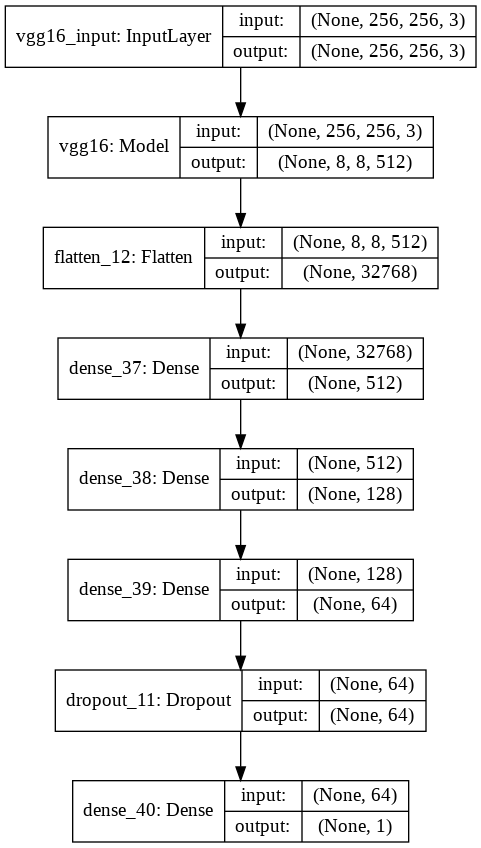

In [ ]:
conv_base = VGG16(weights='imagenet', include_top=False,
                input_shape=(img_rsize, img_csize, img_channels))

for layer in conv_base.layers: 
    layer.trainable = False
    
model_3 = models.Sequential()
model_3.add(conv_base)
model_3.add(layers.Flatten())

model_3.add(layers.Dense(512, activation='relu'))
model_3.add(layers.Dense(128, activation='relu'))
model_3.add(layers.Dense(64, activation='relu'))
model_3.add(layers.Dropout(0.2))

model_3.add(layers.Dense(1, activation='sigmoid')) # 0 , 1
model_3.summary()
plot_model(model_3, show_shapes=True, to_file='VGG16_module.png')

In [ ]:
model_3.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',
              metrics=['acc'])

model_3.fit_generator(train, steps_per_epoch=len(X_train) // BATCH_SIZE,
                             epochs=EPOCHS, validation_data=test,
                             validation_steps=len(X_test) // BATCH_SIZE)

#model_3.save(CV19_path+'saved_model/TrainedModel_3')
model_3.save(CV19_path+'TrainedModel_3')

Epoch 1/20
526/526 [==============================] - 57s 108ms/step - loss: 0.3068 - acc: 0.8737 - val_loss: 0.0446 - val_acc: 0.8865
Epoch 2/20
526/526 [==============================] - 58s 111ms/step - loss: 0.1946 - acc: 0.9225 - val_loss: 0.1481 - val_acc: 0.8547
Epoch 3/20
526/526 [==============================] - 58s 109ms/step - loss: 0.1829 - acc: 0.9282 - val_loss: 0.0864 - val_acc: 0.9512
Epoch 4/20
526/526 [==============================] - 57s 108ms/step - loss: 0.1749 - acc: 0.9329 - val_loss: 0.7871 - val_acc: 0.7543
Epoch 5/20
526/526 [==============================] - 57s 109ms/step - loss: 0.1551 - acc: 0.9417 - val_loss: 0.2761 - val_acc: 0.8948
Epoch 6/20
526/526 [==============================] - 57s 108ms/step - loss: 0.1439 - acc: 0.9451 - val_loss: 0.5800 - val_acc: 0.8633
Epoch 7/20
526/526 [==============================] - 57s 108ms/step - loss: 0.1326 - acc: 0.9491 - val_loss: 0.1032 - val_acc: 0.7964
Epoch 8/20
526/526 [==============================] - 5

##### Transfer Learning from InceptionV3

In [ ]:
conv_base = InceptionV3(weights='imagenet', include_top=False,
                input_shape=(img_rsize, img_csize, img_channels))

for layer in conv_base.layers: 
    layer.trainable = False

model_4 = models.Sequential()
model_4.add(conv_base)
model_4.add(layers.Flatten())

model_4.add(layers.Dense(512, activation='relu'))
model_4.add(layers.Dense(128, activation='relu'))
model_4.add(layers.Dense(64, activation='relu'))
model_4.add(layers.Dropout(0.2))

model_4.add(layers.Dense(1, activation='sigmoid')) # 0 , 1
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 6, 6, 2048)        21802784  
_________________________________________________________________
flatten_3 (Flatten)          (None, 73728)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               37749248  
_________________________________________________________________
dense_10 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                

In [ ]:
model_4.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',
              metrics=['acc'])

model_4.fit_generator(train, steps_per_epoch=len(X_train) // BATCH_SIZE,
                             epochs=EPOCHS, validation_data=test,
                             validation_steps=len(X_test) // BATCH_SIZE)

#model_4.save(CV19_path+'saved_model/TrainedModel_4')
model_4.save(CV19_path+'TrainedModel_4')

Epoch 1/20
526/526 [==============================] - 65s 124ms/step - loss: 0.5471 - acc: 0.8242 - val_loss: 0.7559 - val_acc: 0.7433
Epoch 2/20
526/526 [==============================] - 63s 119ms/step - loss: 0.3145 - acc: 0.8696 - val_loss: 0.5852 - val_acc: 0.7419
Epoch 3/20
526/526 [==============================] - 62s 118ms/step - loss: 0.2558 - acc: 0.8906 - val_loss: 0.3680 - val_acc: 0.7830
Epoch 4/20
526/526 [==============================] - 62s 118ms/step - loss: 0.2421 - acc: 0.9001 - val_loss: 0.0046 - val_acc: 0.8059
Epoch 5/20
526/526 [==============================] - 62s 118ms/step - loss: 0.2389 - acc: 0.9072 - val_loss: 0.3946 - val_acc: 0.8164
Epoch 6/20
526/526 [==============================] - 61s 117ms/step - loss: 0.2349 - acc: 0.9065 - val_loss: 0.4760 - val_acc: 0.7878
Epoch 7/20
526/526 [==============================] - 61s 117ms/step - loss: 0.2273 - acc: 0.9084 - val_loss: 0.0619 - val_acc: 0.8509
Epoch 8/20
526/526 [==============================] - 6

##### Transfer Learning from Xception

In [ ]:
conv_base = Xception(weights='imagenet', include_top=False,
                input_shape=(img_rsize, img_csize, img_channels))

for layer in conv_base.layers: 
    layer.trainable = False

model_5 = models.Sequential()
model_5.add(conv_base)
model_5.add(layers.Flatten())

model_5.add(layers.Dense(512, activation='relu'))
model_5.add(layers.Dense(128, activation='relu'))
model_5.add(layers.Dense(64, activation='relu'))
model_5.add(layers.Dropout(0.2))

model_5.add(layers.Dense(1, activation='sigmoid')) # 0 , 1
model_5.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 8, 8, 2048)        20861480  
_________________________________________________________________
flatten_6 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               67109376  
_________________________________________________________________
dense_22 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_23 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_______________________________________________________

In [ ]:
model_5.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',
              metrics=['acc'])

model_5.fit_generator(train, steps_per_epoch=len(X_train) // BATCH_SIZE,
                             epochs=EPOCHS, validation_data=test,
                             validation_steps=len(X_test) // BATCH_SIZE)

#model_5.save(CV19_path+'saved_model/TrainedModel_5')
model_5.save(CV19_path+'TrainedModel_5')

Epoch 1/20
526/526 [==============================] - 166s 316ms/step - loss: 0.6124 - acc: 0.8287 - val_loss: 0.1575 - val_acc: 0.8702
Epoch 2/20
526/526 [==============================] - 163s 310ms/step - loss: 0.2969 - acc: 0.8808 - val_loss: 0.7760 - val_acc: 0.7992
Epoch 3/20
526/526 [==============================] - 162s 308ms/step - loss: 0.2641 - acc: 0.8944 - val_loss: 0.9462 - val_acc: 0.7533
Epoch 4/20
526/526 [==============================] - 162s 308ms/step - loss: 0.2407 - acc: 0.9006 - val_loss: 0.3413 - val_acc: 0.8250
Epoch 5/20
526/526 [==============================] - 162s 308ms/step - loss: 0.2094 - acc: 0.9208 - val_loss: 0.1909 - val_acc: 0.8614
Epoch 6/20
526/526 [==============================] - 162s 308ms/step - loss: 0.2189 - acc: 0.9137 - val_loss: 0.0023 - val_acc: 0.7648
Epoch 7/20
526/526 [==============================] - 162s 307ms/step - loss: 0.2033 - acc: 0.9225 - val_loss: 0.5075 - val_acc: 0.7572
Epoch 8/20
526/526 [============================

##### Load Models

In [ ]:
#model = models.load_model(CV19_path+'saved_model/TrainedModel_8_20_0.0002')
#model_2 = models.load_model(CV19_path+'saved_model/TrainedModel_2')
#model_3 = models.load_model(CV19_path+'saved_model/TrainedModel_3')
#model_4 = models.load_model(CV19_path+'saved_model/TrainedModel_4')
#model_5 = models.load_model(CV19_path+'saved_model/TrainedModel_5')

## Evaluate on new tests

#### **No Need To Run** Load Trained model if exist

In [ ]:
saved_models = "/content/drive/My Drive/Covid19_Datagen/saved_model/"
saved_model_files = os.listdir(saved_models)
len(saved_model_files)

In [ ]:
if os.path.exists(CV19_path+'TrainedModel_1'):
  model = models.load_model(CV19_path+'TrainedModel_1')
if os.path.exists(CV19_path+'TrainedModel_model_m2'):
  model_m2 = models.load_model(CV19_path+'TrainedModel_model_m2')
if os.path.exists(CV19_path+'TrainedModel_2nd'):
  model_s = models.load_model(CV19_path+'TrainedModel_2nd')

#### Create numpy from test data (reshape -> None, rsize, csize, channels)
- Use ImageDataGenerator (Data Augmentation) in scale only 1/255

In [ ]:
X = np.array([i[0] for i in test_data]).reshape(-1, img_rsize, img_csize, img_channels)
Y = np.array([i[1] for i in test_data]).reshape(-1)

(690, 256, 256, 3) (690,)


#### Predict test data **This For Inception**
- Take img data from datagen flow 
- predict the class using predict
- if pred is greater than 0.5 then covid19 => 1
- else is normal => 0

In [ ]:
z = X/255
predict = inception_model.predict(z, batch_size=BATCH_SIZE)

In [ ]:
i = 0
test_labeled = []
for p in predict:
  if p[0] >= 0.5:
    test_labeled.append([np.array(testfiles[i]), np.array(1)])
  else:
    test_labeled.append([np.array(testfiles[i]), np.array(0)])
  i+=1

#### Predict test data Using Predict Classess
- Scale Test Image
- predict each image Class
- Append the result to test_labeled list

In [ ]:
normal = 0
cov19 = 0


i = 0
z = X/255
test_labeled = []

for x in range(len(z)):

  classes = []
  class_ = model.predict_classes(z[i].reshape(1, img_rsize, img_csize, img_channels))

  #class_ = model_s.predict_classes(z[i].reshape(1, img_rsize, img_csize, img_channels))
  #class_ = model_m2.predict_classes(z[i].reshape(1, img_rsize, img_csize, img_channels))
  #class_ = model_VGG19.predict_classes(z[i].reshape(1, img_rsize, img_csize, img_channels))
  
  
  #class_ = model.predict_classes(z[i].reshape(1, img_rsize, img_csize, img_channels))
  #classes.append(class_[0][0])
  #class_ = model_s.predict_classes(z[i].reshape(1, img_rsize, img_csize, img_channels))
  #classes.append(class_[0][0])
  #class_ = model_m2.predict_classes(z[i].reshape(1, img_rsize, img_csize, img_channels))
  #classes.append(class_[0][0])
  #class_ = model_2.predict_classes(z[i].reshape(1, img_rsize, img_csize, img_channels))
  #classes.append(class_[0][0])
  #class_ = model_3.predict_classes(z[i].reshape(1, img_rsize, img_csize, img_channels))
  #classes.append(class_[0][0])
  #class_ = model_4.predict_classes(z[i].reshape(1, img_rsize, img_csize, img_channels))
  #classes.append(class_[0][0])
  #class_ = model_5.predict_classes(z[i].reshape(1, img_rsize, img_csize, img_channels))
  #classes.append(class_[0][0])


  if classes.count(0) > classes.count(1):
    test_labeled.append([np.array(testfiles[i]), np.array(0)])
    print(i, " : ", classes, " : ", 0)
  elif classes.count(1) > classes.count(0):
    test_labeled.append([np.array(testfiles[i]), np.array(1)])
    print(i, " : ", classes, " : ", 1)
  else:
    print("One Class")

    print(i, " : ", class_[0][0])
    test_labeled.append([np.array(testfiles[i]), class_[0][0]])
  i += 1


#### Predict test data Using Predict Classess using More than one Class



In [ ]:
z = X/255
i = 0
normal = 0
cov19 = 0
test_labeled = []

for x in range(len(z)):

  classes = []
  
  class_ = model.predict_classes(z[i].reshape(1, img_rsize, img_csize, img_channels))
  classes.append(class_[0][0])
  class_ = model_s.predict_classes(z[i].reshape(1, img_rsize, img_csize, img_channels))
  classes.append(class_[0][0])
  class_ = model_m2.predict_classes(z[i].reshape(1, img_rsize, img_csize, img_channels))
  classes.append(class_[0][0])

  #class_ = model_2.predict_classes(z[i].reshape(1, img_rsize, img_csize, img_channels))
  #classes.append(class_[0][0])
  #class_ = model_3.predict_classes(z[i].reshape(1, img_rsize, img_csize, img_channels))
  #classes.append(class_[0][0])
  #class_ = model_4.predict_classes(z[i].reshape(1, img_rsize, img_csize, img_channels))
  #classes.append(class_[0][0])
  #class_ = model_5.predict_classes(z[i].reshape(1, img_rsize, img_csize, img_channels))
  #classes.append(class_[0][0])


  if classes.count(0) > classes.count(1):
    test_labeled.append([np.array(testfiles[i]), np.array(0)])
    print(i, " : ", classes, " : ", 0)

  elif classes.count(1) > classes.count(0):
    test_labeled.append([np.array(testfiles[i]), np.array(1)])
    print(i, " : ", classes, " : ", 1)

  else:
    print("One Class")

    print(i, " : ", class_[0][0])
    test_labeled.append([np.array(testfiles[i]), class_[0][0]])
  i += 1


#### Save the result into CSV
- Make Dateframe (image,label) with the list
- Store it to csv

In [ ]:
df_test = pd.DataFrame(test_labeled, columns=['Image', 'Label'])
df_test.to_csv("/content/drive/My Drive/Covid19_Datagen/Submit.csv", sep=',',index=False)